In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
import math

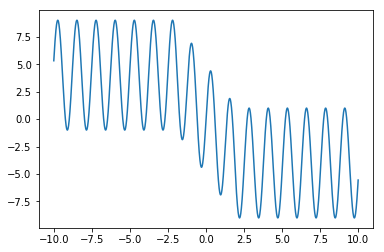

In [2]:
#построение графика функции
func = lambda x: abs(x-2) - abs(x+2) + 5*np.sin(5*x)
# dx Шаг между точками
dx = 0.01
xlist = np.arange(start = -10, stop = 10, step = dx)
ylist = [func(x) for x in xlist]
plt.plot(xlist, ylist)
plt.savefig('ini_func.png', bbox_inches='tight')

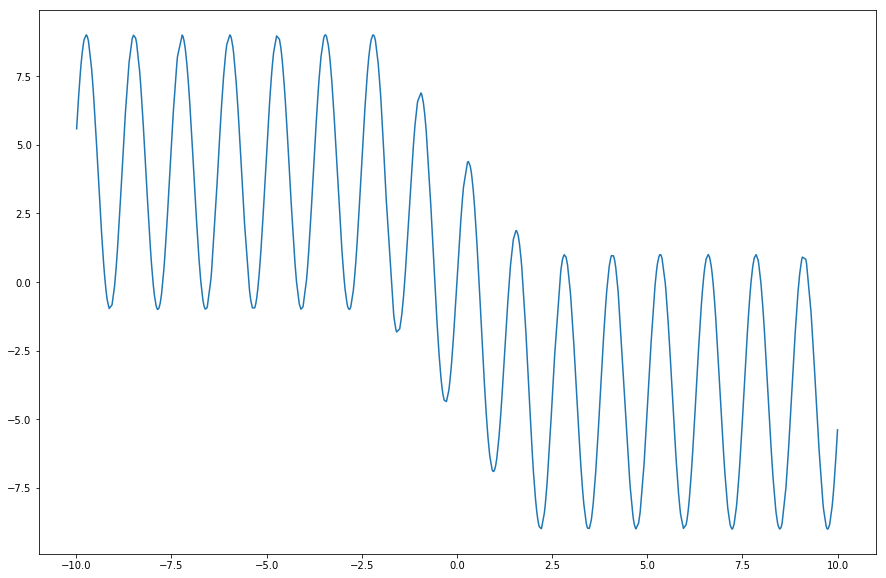

In [3]:
#Формирование исходных данных
#рандомно выберем точки на оси Х
X_data = 20 * (np.random.random(800) - 0.5)
X_data.sort()
Y_data = [func(x) for x in X_data]
data = np.array(list(zip(X_data, Y_data)))

plt.figure(figsize=(15,10))
plt.plot(data[:, 0], data[:, 1])

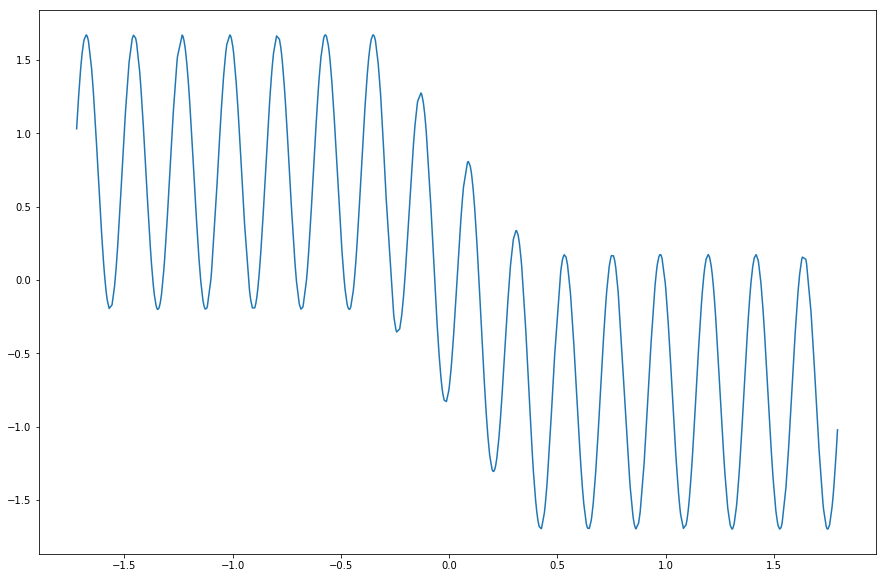

In [4]:
# Преобразование данных
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(data)

plt.figure(figsize=(15,10))
plt.plot(data[:, 0], data[:, 1])

In [5]:
#премешать
np.random.shuffle(data)
print(data[:5])

[[ 1.48242308 -1.03175853]
 [-0.62971147  0.66532262]
 [ 1.15172968 -0.47394699]
 [ 1.27225808 -1.29032612]
 [-0.97671689  1.19648089]]



 480 240 80


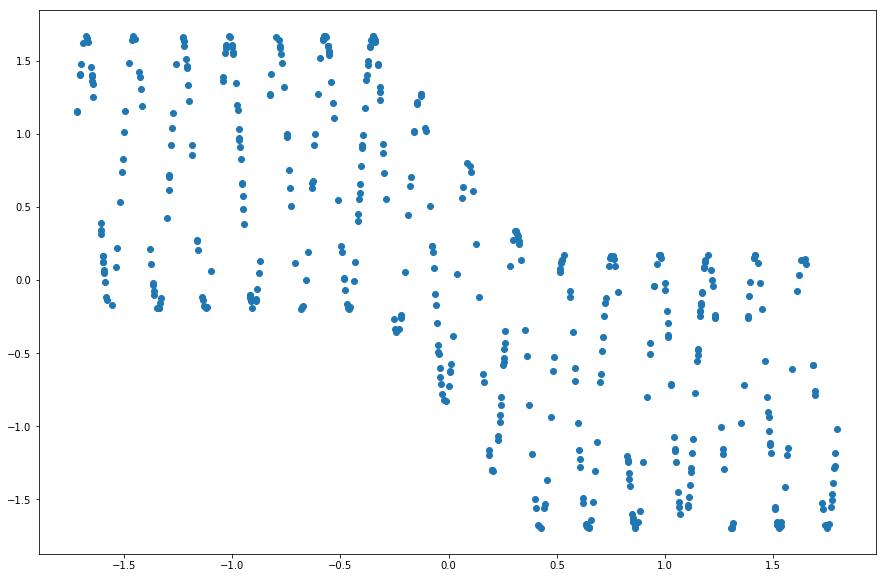

In [6]:
#отметим границы
train_border = [0, int(len(data)*0.6)]
valid_border = [int(len(data)*0.6), int(len(data)*0.9)]
test_border = [int(len(data)*0.9), len(data)]

#делим 
learn_data = data[train_border[0]: train_border[1]]
valid_data = data[valid_border[0]: valid_border[1]]
test_data = data[test_border[0]: test_border[1]]

print('\n', len(learn_data), len(valid_data), len(test_data))
plt.figure(figsize=(15, 10))
plt.scatter(learn_data[:, 0], learn_data[:, 1])


In [7]:
class SinDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    

In [8]:
dataset = SinDataset(learn_data)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

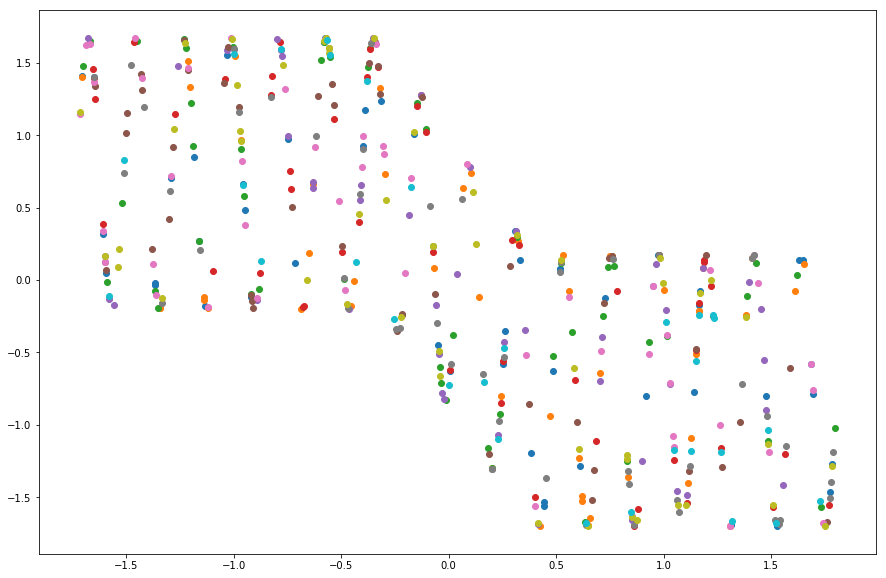

In [9]:
plt.figure(figsize=(15, 10))
for i in dataloader:
    plt.scatter(i[:, 0], i[:, 1])

In [10]:
class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()
        self.lin1 = nn.Linear(1, 30)
        self.lin2 = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.tanh(x)
        x = self.lin2(x)
        x = F.tanh(x)
        return x

In [11]:
net = MainNet()
net

MainNet(
  (lin1): Linear(in_features=1, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=1, bias=True)
)

In [12]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>




Columns 0 to 9 
-0.1803 -0.3792  0.0171 -0.2742 -0.6452 -0.5622  0.3613  0.8127 -0.8580 -0.9065

Columns 10 to 19 
-0.4263 -0.1906  0.6418  0.3540 -0.2069 -0.6622  0.9430  0.1037 -0.7379 -0.6335

Columns 20 to 29 
-0.8404  0.9799  0.0650 -0.2135 -0.3844  0.4599 -0.0521  0.3941  0.7582 -0.4779
[torch.FloatTensor of size 1x30]

In [13]:
stds = [math.sqrt(2/32), math.sqrt(2/32)]
stds.reverse()
def init_weights(layer):
    if (type(layer) == nn.Linear):
        layer.weight.data = torch.randn(layer.weight.data.shape)*stds.pop()
        
net.apply(init_weights)

MainNet(
  (lin1): Linear(in_features=1, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=1, bias=True)
)

In [14]:
print(type(net.lin1.weight))
net.lin1.weight.data.t()

<class 'torch.nn.parameter.Parameter'>




Columns 0 to 9 
 0.1110 -0.1812 -0.0021 -0.1475 -0.1016  0.1958  0.2789  0.3432 -0.2593  0.0177

Columns 10 to 19 
-0.3643  0.1021 -0.3212 -0.4049 -0.1661  0.5854 -0.0209  0.2436 -0.1199  0.0557

Columns 20 to 29 
-0.2136  0.0546 -0.2856 -0.0715 -0.1341  0.1975  0.3433  0.0380  0.1138 -0.4253
[torch.FloatTensor of size 1x30]

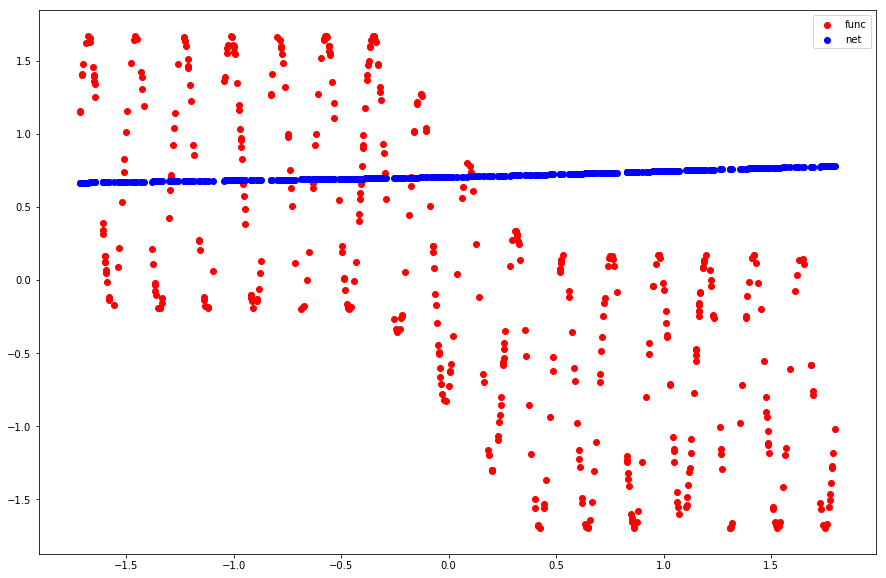

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(learn_data[:, 0], learn_data[:, 1], c='r', label='func')

inputs = autograd.Variable((torch.from_numpy(learn_data[:, 0]).float()).unsqueeze(1))
predict = net.forward(inputs).data.numpy()
plt.scatter(learn_data[:, 0], predict, c='b', label='net')
plt.legend()
plt.savefig('before_training.png', bbox_inches='tight')

In [16]:
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
l1w = []
l2w = []
l1b = []
l2b = []
num_epoh = []
loss_epoh = []
valid_loss_epoh = []
test_loss_epoh = []
for epoh in range(5*10**5):
    if epoh % 10000 == 0:
        print("epoh", epoh)
    loss_acc = 0
    for mini_batch in dataloader:
        learn_inputs = autograd.Variable(mini_batch[:, 0].float()).unsqueeze(1)
        learn_labels = autograd.Variable(mini_batch[:, 1].float()).unsqueeze(1)
        
        optimizer.zero_grad()
        learn_output = net(learn_inputs)
        loss = criterion(learn_output, learn_labels)
        loss.backward()
        optimizer.step()
        loss_acc += loss.data[0]
    loss_epoh.append(loss_acc)
    
    valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0]).float()).unsqueeze(1)
    valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, 1]).float()).unsqueeze(1)
    test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0]).float()).unsqueeze(1)
    test_labels = autograd.Variable(torch.from_numpy(test_data[:, 1]).float()).unsqueeze(1)
    valid_output = net(valid_inputs)
    valid_loss = criterion(valid_output, valid_labels).data.numpy()
    test_output = net(test_inputs)
    test_loss = criterion(test_output, test_labels).data.numpy()
    valid_loss_epoh.append(np.sum(valid_loss))
    test_loss_epoh.append(np.sum(test_loss))

    if epoh % 10000 == 0:
        num_epoh.append(epoh)
        for num, i in enumerate(net.parameters()):
            if num == 0:
                l1w.append(np.copy(i.data.numpy()))
            if num == 1:
                l2w.append(np.copy(i.data.numpy()))
            if num == 2:
                l1b.append(np.copy(i.data.numpy()))
            if num == 3:
                l2b.append(np.copy(i.data.numpy()))

epoh 0
epoh 10000
epoh 20000
epoh 30000
epoh 40000
epoh 50000
epoh 60000
epoh 70000
epoh 80000
epoh 90000
epoh 100000
epoh 110000
epoh 120000
epoh 130000
epoh 140000
epoh 150000
epoh 160000
epoh 170000
epoh 180000
epoh 190000
epoh 200000
epoh 210000
epoh 220000
epoh 230000
epoh 240000
epoh 250000
epoh 260000
epoh 270000
epoh 280000
epoh 290000
epoh 300000
epoh 310000
epoh 320000
epoh 330000
epoh 340000
epoh 350000
epoh 360000


In [ ]:
l1w = np.array(l1w)
l2w = np.array(l2w)
l1b = np.array(l1b)
l2b = np.array(l2b)
l2b.shape

In [ ]:
plt.plot(loss_epoh, color='r', label = 'learn')
plt.plot(valid_loss_epoh, color='b', label = 'valid')
plt.plot(test_loss_epoh, color='g', label = 'test')
plt.legend()
plt.savefig('train_valid_test.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(30,30))
for i in range(30):
    plt.subplot(6, 5, 1 + i )
    plt.plot(num_epoh, l1w[:, i, 0])
    plt.title('l1 w' + str(i+1)+' 1')
plt.savefig('l1w.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(30,30))
for i in range(30):
    plt.subplot(6, 5, 1 + i )
    plt.plot(num_epoh, l2w[:, i])
    plt.title('l2 w' + str(i+1)+' 1')
plt.savefig('l2w.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(30,30))
for i in range(30):
    plt.subplot(6, 5, 1 + i )
    plt.plot(num_epoh, l1b[:, 0, i])
    plt.title('l1 b' + str(i+1))
plt.savefig('l1b.png', bbox_inches='tight')

In [ ]:
plt.plot(num_epoh, l2b[:, 0])
plt.title('l2 b')
plt.savefig('l2b.png', bbox_inches='tight')

In [ ]:
print("train:")
print(max(loss_epoh))
print(math.sqrt(np.var(loss_epoh)))
print(math.sqrt(np.mean(loss_epoh)))

In [ ]:
df_buf = pd.DataFrame(dataset.data)
df_buf = df_buf.sort_values(by=0)

x = autograd.Variable((torch.from_numpy(df_buf.get_values()[:, 0]).float()).unsqueeze(1))
y = net.forward(x)
x = x.data.numpy()
y = y.data.numpy()
print(min(y), max(y))
plt.figure(figsize=(15,10))
plt.plot(df_buf[0], df_buf[1], color='r')
plt.plot(x, y)
plt.savefig('after_training1.png', bbox_inches='tight')